In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def fft_analysis(signal):
    slope, intercept = np.polyfit(np.arange(len(signal)), signal, 1)
    trend = np.arange(len(signal)) * slope + intercept
    detrended = signal - trend
    fft_values = np.fft.fft(detrended)
    frequencies = np.fft.fftfreq(len(fft_values))
    # Remove negative frequencies and sort
    positive_frequencies = frequencies[frequencies > 0]
    magnitudes = np.abs(fft_values)[frequencies > 0]
    # Identify dominant frequency
    dominant_frequency = positive_frequencies[np.argmax(magnitudes)]
    #print(f"Dominant Frequency: {dominant_frequency:.3f}")
    # Convert frequency to period (e.g., days, weeks, months, etc.)
    dominant_period = 1 / dominant_frequency
    #print(f"Dominant Period: {dominant_period:.2f} time units")
    return dominant_frequency

In [ ]:
import os

def process_file(file_path):
    data = pd.read_csv(file_path)

    data.columns = [
        "tachometer",
        "acc_under_axial",
        "acc_under_radiale",
        "acc_under_tangencial",
        "acc_over_axial",
        "acc_over_radiale",
        "acc_over_tangencial",
        "microphone",
    ]

    statistics_dict = {}

    for col in data.columns:
        statistics_dict[f'{col}_mean'] = data[col].mean()
        statistics_dict[f'{col}_median'] = data[col].median()
        statistics_dict[f'{col}_std'] = data[col].std()
        statistics_dict[f'{col}_variance'] = data[col].var()
        statistics_dict[f'{col}_range'] = data[col].max() - data[col].min()
        statistics_dict[f'{col}_skewness'] = data[col].skew()
        statistics_dict[f'{col}_kurtosis'] = data[col].kurt()
        statistics_dict[f'{col}_dominant_frequency'] = fft_analysis(data[col])

    label = "_".join(os.path.normpath(file_path).split(os.sep)[-3:-1])
    statistics_dict['label'] = label

    return statistics_dict


def process_directory(root_dir):
    all_statistics = []

    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith(".csv"):
                file_path = os.path.join(subdir, file)
                print(f"Procesando archivo: {file_path}")
                try:
                    stats = process_file(file_path)
                    all_statistics.append(stats)
                except Exception as e:
                    print(f"Error procesando {file_path}: {e}")

    combined_df = pd.DataFrame(all_statistics)
    return combined_df

def process_directory_reduced(root_dir):
    all_statistics = []

    target_dirs = ["horizontal-misalignment", "vertical-misalignment"]

    for subdir, _, files in os.walk(root_dir):
        if any(target_dir in subdir for target_dir in target_dirs):
            for file in files:
                if file.endswith(".csv"):
                    file_path = os.path.join(subdir, file)
                    # print(f"Procesando archivo: {file_path}")
                    try:
                        stats = process_file(file_path)
                        all_statistics.append(stats)
                    except Exception as e:
                        print(f"Error procesando {file_path}: {e}")

    combined_df = pd.DataFrame(all_statistics)
    return combined_df

root_dir = '../bearing_fault_detection_reduced'
output_csv_path = 'combined_statistics.csv'
output_csv_path_reduced = 'combined_statistics_reduced.csv'

combined_df = process_directory(root_dir)
combined_df.to_csv(output_csv_path, index=False)

reduced_df = process_directory_reduced(root_dir)
combined_df.to_csv(output_csv_path_reduced, index=False)

print(f"Archivo grande combinado guardado en: {output_csv_path}")
print(f"Archivo pequeño combinado guardado en: {output_csv_path}")


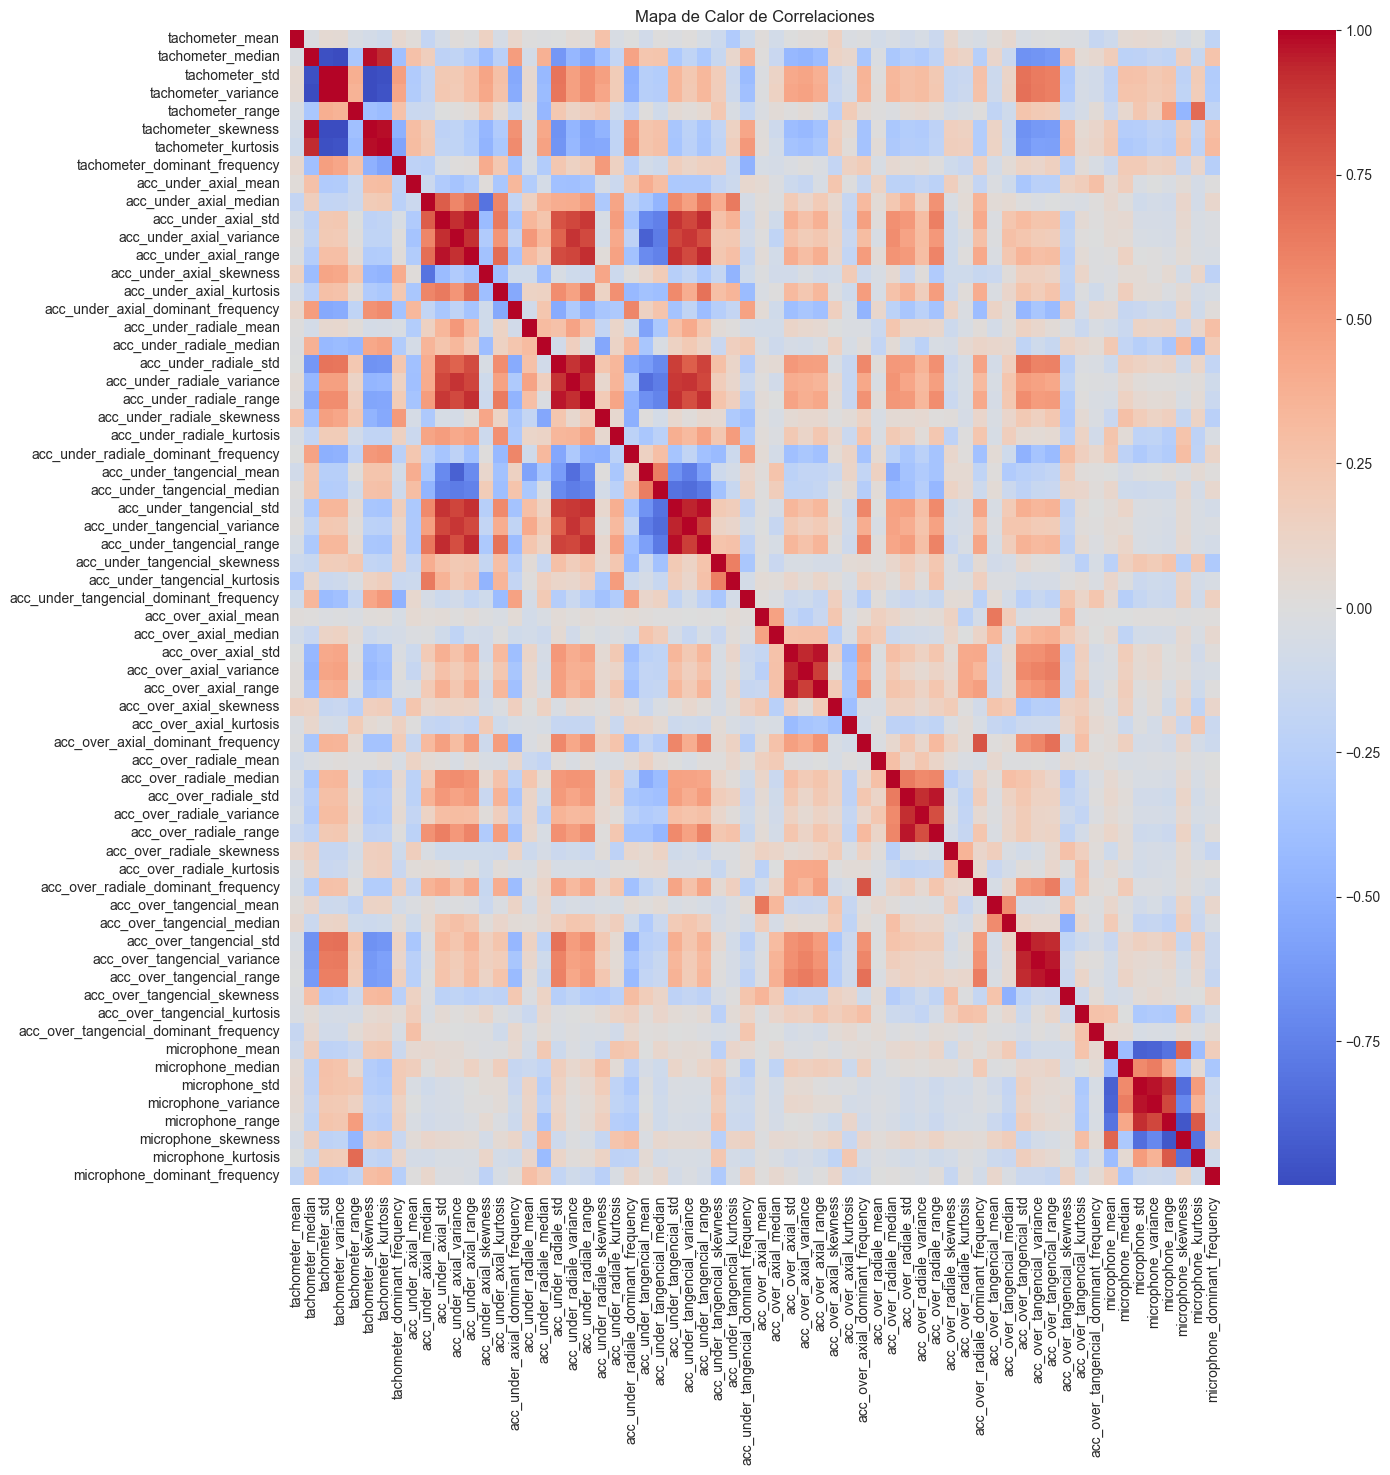


Highly correlated feature pairs (|correlation| > 0.9):
tachometer_median & tachometer_std: -0.981
tachometer_median & tachometer_variance: -0.992
tachometer_median & tachometer_skewness: 0.978
tachometer_median & tachometer_kurtosis: 0.927
tachometer_std & tachometer_variance: 0.997
tachometer_std & tachometer_skewness: -0.999
tachometer_std & tachometer_kurtosis: -0.980
tachometer_variance & tachometer_skewness: -0.995
tachometer_variance & tachometer_kurtosis: -0.964
tachometer_skewness & tachometer_kurtosis: 0.984
acc_under_axial_std & acc_under_axial_variance: 0.918
acc_under_axial_std & acc_under_axial_range: 0.977
acc_under_axial_std & acc_under_tangencial_std: 0.901
acc_under_axial_std & acc_under_tangencial_range: 0.922
acc_under_axial_variance & acc_under_axial_range: 0.907
acc_under_axial_variance & acc_under_radiale_variance: 0.904
acc_under_axial_variance & acc_under_tangencial_mean: -0.901
acc_under_axial_range & acc_under_radiale_range: 0.918
acc_under_axial_range & acc_

In [4]:
import seaborn as sns

# Carga el archivo CSV
ruta_csv = 'combined_statistics.csv'  # Cambia esto por la ruta de tu archivo
df = pd.read_csv(ruta_csv)


X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Calcula la matriz de correlación
correlaciones = X.corr()

# Configura el tamaño del gráfico
plt.figure(figsize=(15, 15))

# Genera el mapa de calor
sns.heatmap(correlaciones, annot=False, cmap='coolwarm', cbar=True)

# Personaliza el gráfico
plt.title('Mapa de Calor de Correlaciones')
plt.show()

# Buscar pares de características altamente correlacionadas (|correlation| > 0.9)
print("\nHighly correlated feature pairs (|correlation| > 0.9):")
high_corr = np.where(np.abs(correlaciones) > 0.9)

# Imprimir las parejas, asegurando que no se repitan (i < j evita duplicados y la diagonal)
for i, j in zip(*high_corr):
    if i < j:
        print(f"{correlaciones.index[i]} & {correlaciones.columns[j]}: {correlaciones.iloc[i, j]:.3f}")


Como en la imagen no se ve muy claro, las ordenaré de mayor a menor en absoluto

Las que están más correlados son las que no las necesitamos, ya que los dos nos darían la misma o muy parecida información.

In [5]:
correlaciones_desordenadas = correlaciones.unstack()
correlaciones_ordenadas = correlaciones_desordenadas.abs().sort_values(ascending=False)

correlaciones_filtradas = correlaciones_ordenadas[correlaciones_ordenadas.index.get_level_values(0) != correlaciones_ordenadas.index.get_level_values(1)]

print("Correlaciones más fuertes:")
print(len(correlaciones_filtradas))
print(correlaciones_filtradas.head(4032)) #aqui pongo las correlaciones que queremos

Correlaciones más fuertes:
4032
tachometer_skewness      tachometer_std             0.999238
tachometer_std           tachometer_skewness        0.999238
tachometer_variance      tachometer_std             0.997455
tachometer_std           tachometer_variance        0.997455
tachometer_skewness      tachometer_variance        0.995284
                                                      ...   
acc_over_axial_mean      microphone_median          0.000258
acc_under_radiale_mean   acc_over_axial_skewness    0.000114
acc_over_axial_skewness  acc_under_radiale_mean     0.000114
acc_over_axial_std       tachometer_mean            0.000007
tachometer_mean          acc_over_axial_std         0.000007
Length: 4032, dtype: float64


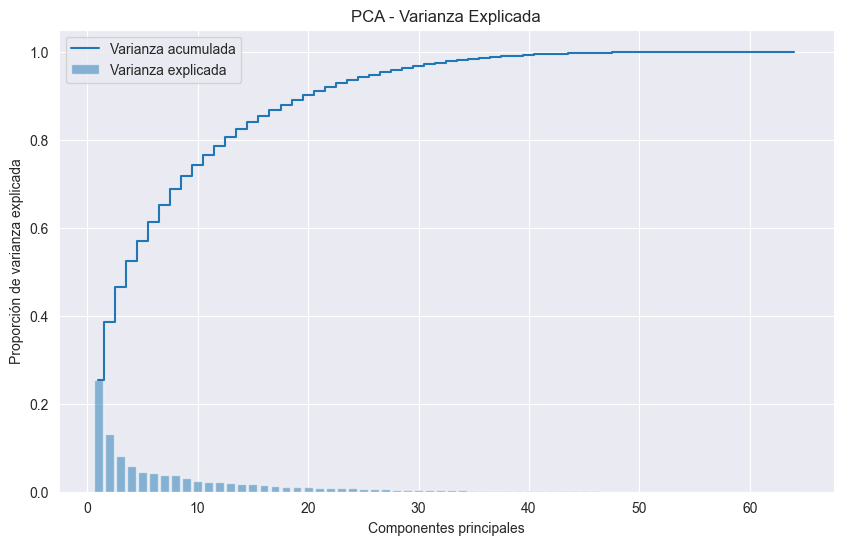

Varianza explicada por componente:
Componente 1: 0.2533
Componente 2: 0.1313
Componente 3: 0.0803
Componente 4: 0.0592
Componente 5: 0.0450
Componente 6: 0.0429
Componente 7: 0.0386
Componente 8: 0.0371
Componente 9: 0.0304
Componente 10: 0.0234
Componente 11: 0.0227
Componente 12: 0.0216
Componente 13: 0.0202
Componente 14: 0.0176
Componente 15: 0.0167
Componente 16: 0.0143
Componente 17: 0.0132
Componente 18: 0.0117
Componente 19: 0.0113
Componente 20: 0.0107
Componente 21: 0.0095
Componente 22: 0.0091
Componente 23: 0.0085
Componente 24: 0.0074
Componente 25: 0.0064
Componente 26: 0.0057
Componente 27: 0.0054
Componente 28: 0.0050
Componente 29: 0.0046
Componente 30: 0.0043
Componente 31: 0.0040
Componente 32: 0.0035
Componente 33: 0.0032
Componente 34: 0.0028
Componente 35: 0.0025
Componente 36: 0.0024
Componente 37: 0.0021
Componente 38: 0.0018
Componente 39: 0.0017
Componente 40: 0.0014
Componente 41: 0.0011
Componente 42: 0.0010
Componente 43: 0.0009
Componente 44: 0.0007
Compon

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

ruta_csv = 'combined_statistics.csv'
df = pd.read_csv(ruta_csv)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Varianza explicada por cada componente
varianza_explicada = pca.explained_variance_ratio_
varianza_acumulada = np.cumsum(varianza_explicada)


plt.figure(figsize=(10, 6))
plt.bar(range(1, len(varianza_explicada) + 1), varianza_explicada, alpha=0.5, align='center', label='Varianza explicada')
plt.step(range(1, len(varianza_acumulada) + 1), varianza_acumulada, where='mid', label='Varianza acumulada')
plt.xlabel('Componentes principales')
plt.ylabel('Proporción de varianza explicada')
plt.title('PCA - Varianza Explicada')
plt.legend(loc='best')
plt.show()


print("Varianza explicada por componente:")
for i, var in enumerate(varianza_explicada, start=1):
    print(f"Componente {i}: {var:.4f}")

n_componentes_optimos = np.argmax(varianza_acumulada >= 0.9) + 1
print(f"\nNúmero óptimo de componentes para capturar el 90% de la varianza: {n_componentes_optimos}")

pca_optimo = PCA(n_components=n_componentes_optimos)
X_reducido = pca_optimo.fit_transform(X_scaled)

print(f"Conjunto de datos reducido a {n_componentes_optimos} componentes principales.")
correlation_matrix = pd.DataFrame(X_scaled, columns=X.columns).corr()


90% cogeremos en PCA --> 20 componentes

Con 20 componentes podemos explicar el 90% de la variabilidad

95% --> 27 componentes

In [7]:
loadings = pca.components_

loadings_df = pd.DataFrame(loadings, columns=X.columns)

In [8]:
loadings_df.head(20)

,tachometer_mean,tachometer_median,tachometer_std,tachometer_variance,tachometer_range,tachometer_skewness,tachometer_kurtosis,tachometer_dominant_frequency,acc_under_axial_mean,acc_under_axial_median,...,acc_over_tangencial_kurtosis,acc_over_tangencial_dominant_frequency,microphone_mean,microphone_median,microphone_std,microphone_variance,microphone_range,microphone_skewness,microphone_kurtosis,microphone_dominant_frequency
0,-0.000917,-0.169003,0.175954,0.174902,0.054739,-0.175326,-0.173609,0.071331,-0.104132,0.103867,...,-0.003700,-0.017310,-0.025428,0.056220,0.034347,0.028167,0.027750,-0.022800,0.019528,-0.042111
1,-0.043176,0.184028,-0.200056,-0.194648,-0.164158,0.200854,0.208958,-0.142931,-0.002792,0.221725,...,0.052717,0.027206,0.179700,-0.116217,-0.204245,-0.180361,-0.215056,0.205491,-0.172834,0.100389
2,-0.000146,0.102407,-0.080667,-0.087587,0.087685,0.081300,0.062173,0.002737,-0.030213,0.121067,...,-0.187978,-0.012672,-0.255019,0.113874,0.282128,0.262815,0.294321,-0.283818,0.213009,-0.015141
3,0.046433,-0.095273,0.112248,0.104303,0.048292,-0.116927,-0.133397,0.181281,-0.065593,-0.166553,...,-0.054539,-0.018305,0.180385,-0.114502,-0.168934,-0.190560,-0.155904,0.129911,-0.058521,-0.049793
4,-0.162010,0.041280,-0.022277,-0.032222,0.081895,0.015990,-0.009023,0.117156,0.004575,0.218969,...,0.016298,-0.032036,0.083159,0.017771,-0.071558,-0.087586,-0.044510,0.037745,0.018404,-0.090967
5,-0.022122,-0.036171,0.018433,0.028611,-0.102260,-0.012518,0.011481,-0.130437,0.114727,0.036931,...,-0.133272,0.005025,-0.086653,0.106380,0.074293,0.111907,0.021683,0.004200,-0.073252,0.049186
6,0.199385,0.027536,-0.006875,-0.017192,-0.163874,-0.002131,-0.027982,0.134462,0.178724,-0.032082,...,0.162450,-0.018433,-0.056546,0.318137,0.075280,0.111212,-0.040464,0.068574,-0.187166,-0.150145
7,0.130056,0.017084,-0.000733,-0.009261,-0.031064,-0.005669,-0.026032,0.134815,0.046573,-0.000431,...,0.150670,0.026424,-0.030314,0.107199,0.015420,0.014844,-0.010725,0.003379,-0.027815,-0.154990
8,-0.031229,0.058813,-0.050411,-0.051908,0.203858,0.053309,0.048262,-0.019570,0.251493,-0.025444,...,0.309407,0.328903,0.018152,0.061831,-0.063816,-0.081453,0.027753,-0.046601,0.148802,-0.204157
9,-0.091323,-0.052565,0.023489,0.037329,0.309549,-0.016681,0.017716,-0.121907,0.048711,0.037881,...,0.124958,0.009894,0.130435,-0.159737,-0.087712,-0.122910,0.069316,-0.103751,0.304411,-0.007733


In [9]:
# Filtrar las cargas con valor absoluto mayor que 0.4
filtered_loadings = loadings_df.applymap(lambda x: x if abs(x) > 0.2 else None)


for i in range(20):
    print(f"Componente Principal {i+1}:")
    print(filtered_loadings.loc[i].dropna())
    print("\n")

Componente Principal 1:
acc_under_axial_range         0.206812
acc_under_radiale_std         0.238527
acc_under_radiale_variance    0.213323
acc_under_radiale_range       0.233239
acc_under_tangencial_std      0.209431
acc_under_tangencial_range    0.209155
Name: 0, dtype: float64


Componente Principal 2:
tachometer_std             -0.200056
tachometer_skewness         0.200854
tachometer_kurtosis         0.208958
acc_under_axial_median      0.221725
acc_under_axial_skewness   -0.207610
acc_under_radiale_median    0.221161
microphone_std             -0.204245
microphone_range           -0.215056
microphone_skewness         0.205491
Name: 1, dtype: float64


Componente Principal 3:
acc_over_tangencial_range   -0.206711
microphone_mean             -0.255019
microphone_std               0.282128
microphone_variance          0.262815
microphone_range             0.294321
microphone_skewness         -0.283818
microphone_kurtosis          0.213009
Name: 2, dtype: float64


Componente Princi

C:\Users\hodei\AppData\Local\Temp\ipykernel_18208\3005809403.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  filtered_loadings = loadings_df.applymap(lambda x: x if abs(x) > 0.2 else None)


In [10]:
variables_importantes = []

# Filtrar las cargas con valor absoluto mayor que 0.4 y acumular los nombres de las variables
for i in range(20):
    print(f"Componente Principal {i+1}:")
    high_contrib = loadings_df.loc[i].abs().sort_values(ascending=False).head(4)
    print(high_contrib)
    print("\n")

    for variable in high_contrib.index:
        if variable not in variables_importantes:
            variables_importantes.append(variable)

print("Variables con alta contribución en las primeras 19 componentes principales:")
print(variables_importantes)
print(len(variables_importantes))

Componente Principal 1:
acc_under_radiale_std         0.238527
acc_under_radiale_range       0.233239
acc_under_radiale_variance    0.213323
acc_under_tangencial_std      0.209431
Name: 0, dtype: float64


Componente Principal 2:
acc_under_axial_median      0.221725
acc_under_radiale_median    0.221161
microphone_range            0.215056
tachometer_kurtosis         0.208958
Name: 1, dtype: float64


Componente Principal 3:
microphone_range       0.294321
microphone_skewness    0.283818
microphone_std         0.282128
microphone_variance    0.262815
Name: 2, dtype: float64


Componente Principal 4:
acc_under_axial_skewness    0.256956
acc_over_axial_range        0.256424
acc_over_axial_std          0.251727
acc_over_axial_variance     0.245747
Name: 3, dtype: float64


Componente Principal 5:
acc_under_tangencial_kurtosis              0.357729
acc_under_tangencial_skewness              0.315925
acc_under_tangencial_mean                  0.238821
acc_under_tangencial_dominant_frequency 

como estamos haciendo no fallo vs cada fallo, no fallo vs fallo, los datos ya están balanceados, por lo que no hay que balancearlos de antemano, ya que para cada grupo hay 4 datos.

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report


from sklearn.model_selection import GridSearchCV, train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
#stratify --> y bakoitza 80%-tan banatzeko

rf_param_grid = {
    'n_estimators': range(50, 200, 10),
    'max_depth': range(1,30,2),
    'min_samples_split': range(2,60,2),
    'min_samples_leaf': range(1,60,2),
}

# GridSearchCV para encontrar los mejores hiperparámetros
print("Optimizing Random Forest...")
rf_grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)
rf_grid_search.fit(X_train, y_train)
print(f"Best Random Forest Params: {rf_grid_search.best_params_}")


In [15]:
best_rf = RandomForestClassifier(max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=50, random_state=42)
best_rf.fit(X_train, y_train)

rf_train_pred = best_rf.predict(X_train)
rf_test_pred = best_rf.predict(X_test)

print("\nClassification Report (Training):")
print(classification_report(y_train, rf_train_pred))

print("\nClassification Report (Testing):")
print(classification_report(y_test, rf_test_pred))


Classification Report (Training):
                                        precision    recall  f1-score   support

                         ball_fault_0g       0.88      1.00      0.93         7
                        ball_fault_20g       1.00      0.71      0.83         7
                        ball_fault_35g       0.78      1.00      0.88         7
                         ball_fault_6g       1.00      0.83      0.91         6
bearing_fault_detection_reduced_normal       1.00      1.00      1.00         3
                         cage_fault_0g       1.00      1.00      1.00         6
                        cage_fault_20g       1.00      1.00      1.00         7
                        cage_fault_35g       1.00      1.00      1.00         6
                         cage_fault_6g       1.00      1.00      1.00         6
         horizontal-misalignment_0.5mm       0.75      1.00      0.86         3
         horizontal-misalignment_1.0mm       1.00      1.00      1.00         3
    

C:\Users\hodei\.conda\envs\PythonProject\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hodei\.conda\envs\PythonProject\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hodei\.conda\envs\PythonProject\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r


Feature Importance Analysis:


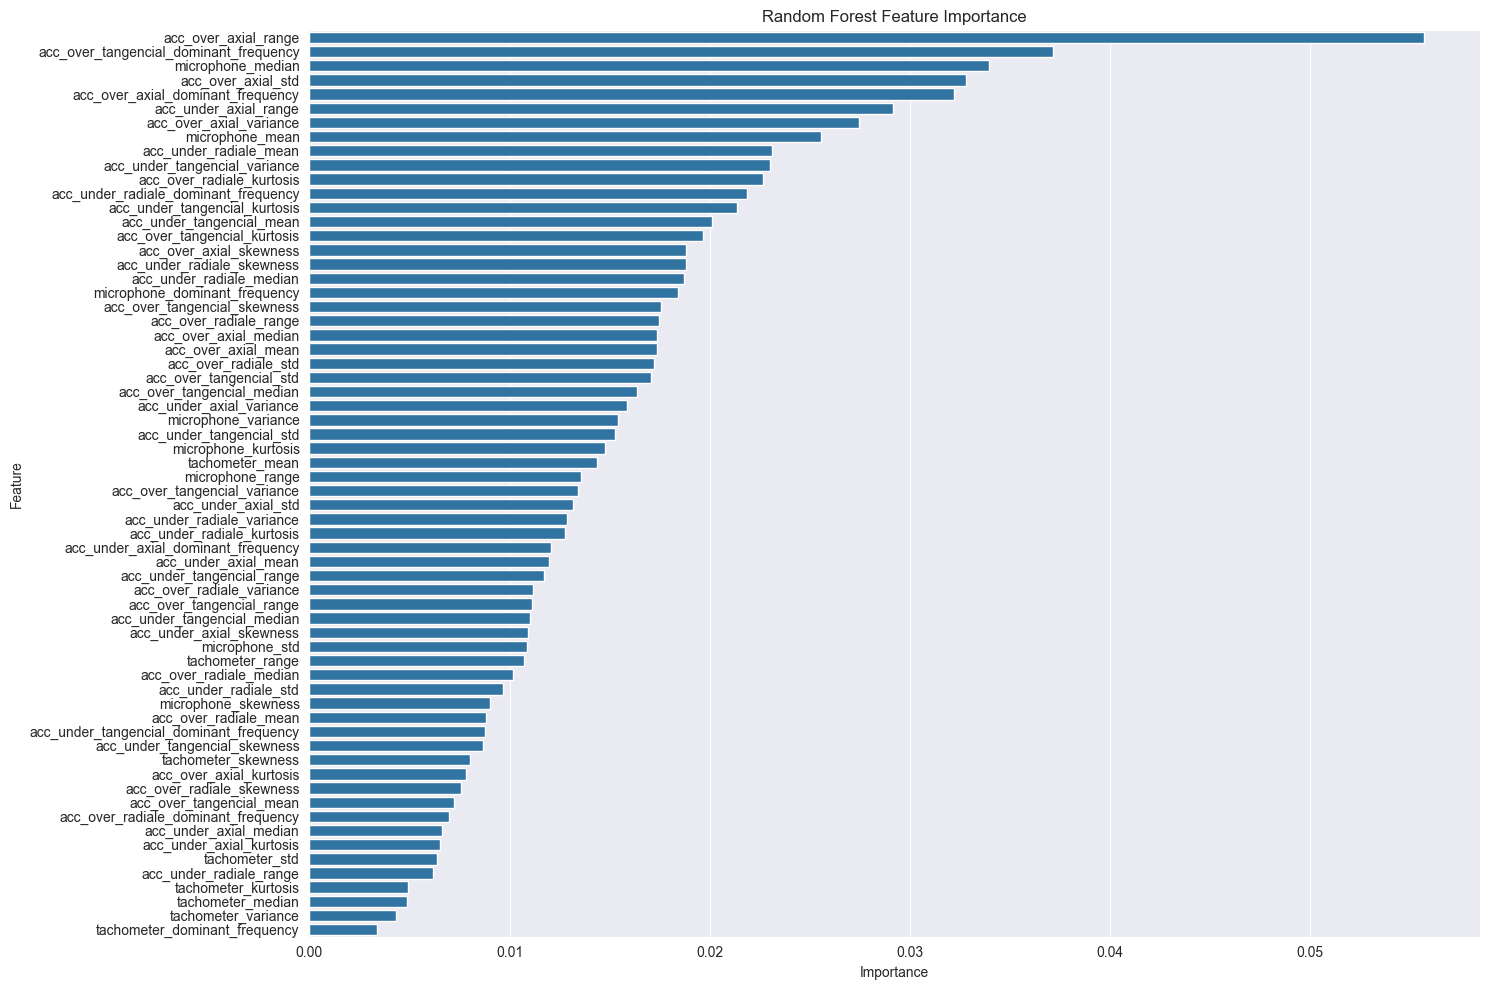


Feature Importance Ranking:
                                   feature  importance
36                    acc_over_axial_range    0.055703
55  acc_over_tangencial_dominant_frequency    0.037142
57                       microphone_median    0.033933
34                      acc_over_axial_std    0.032818
39       acc_over_axial_dominant_frequency    0.032202
..                                     ...         ...
20                 acc_under_radiale_range    0.006179
6                      tachometer_kurtosis    0.004944
1                        tachometer_median    0.004870
3                      tachometer_variance    0.004305
7            tachometer_dominant_frequency    0.003356

[64 rows x 2 columns]


In [16]:
def plot_feature_importance(model, feature_names, title="Feature Importance"):
    importances = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(15, 10))
    sns.barplot(data=importances, x='importance', y='feature')
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

    return importances

print("\nFeature Importance Analysis:")
importance_df = plot_feature_importance(best_rf, X.columns,
                                     "Random Forest Feature Importance")
print("\nFeature Importance Ranking:")
print(importance_df)

Para la explicación de la varianza escogeremos 90% de importancia.

In [17]:
total_importance = importance_df['importance'].sum()
# print(total_importance) --> efektibamente da 1

cumulative_importance = importance_df['importance'].cumsum()
selected_features = importance_df[cumulative_importance <= total_importance * 0.9] #coger el 90% de importancia

print("\nSelected Features (90% of importance):")
print(selected_features)


Selected Features (90% of importance):
                                   feature  importance
36                    acc_over_axial_range    0.055703
55  acc_over_tangencial_dominant_frequency    0.037142
57                       microphone_median    0.033933
34                      acc_over_axial_std    0.032818
39       acc_over_axial_dominant_frequency    0.032202
12                   acc_under_axial_range    0.029136
35                 acc_over_axial_variance    0.027472
56                         microphone_mean    0.025565
16                  acc_under_radiale_mean    0.023136
27           acc_under_tangencial_variance    0.022998
46               acc_over_radiale_kurtosis    0.022672
23    acc_under_radiale_dominant_frequency    0.021857
30           acc_under_tangencial_kurtosis    0.021375
24               acc_under_tangencial_mean    0.020126
54            acc_over_tangencial_kurtosis    0.019690
37                 acc_over_axial_skewness    0.018839
21              acc_under

In [18]:
X = X[selected_features['feature']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

best_rf.fit(X_train, y_train)

rf_train_pred = best_rf.predict(X_train)
rf_test_pred = best_rf.predict(X_test)

print("\nClassification Report (Training):")
print(classification_report(y_train, rf_train_pred))

print("\nClassification Report (Testing):")
print(classification_report(y_test, rf_test_pred))


Classification Report (Training):
                                        precision    recall  f1-score   support

                         ball_fault_0g       1.00      1.00      1.00         6
                        ball_fault_20g       1.00      1.00      1.00         7
                        ball_fault_35g       1.00      1.00      1.00         6
                         ball_fault_6g       1.00      1.00      1.00         4
bearing_fault_detection_reduced_normal       1.00      1.00      1.00         3
                         cage_fault_0g       1.00      1.00      1.00         8
                        cage_fault_20g       1.00      1.00      1.00         6
                        cage_fault_35g       1.00      1.00      1.00         7
                         cage_fault_6g       1.00      1.00      1.00         7
         horizontal-misalignment_0.5mm       1.00      1.00      1.00         4
         horizontal-misalignment_1.0mm       1.00      1.00      1.00         4
    

C:\Users\hodei\.conda\envs\PythonProject\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hodei\.conda\envs\PythonProject\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hodei\.conda\envs\PythonProject\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


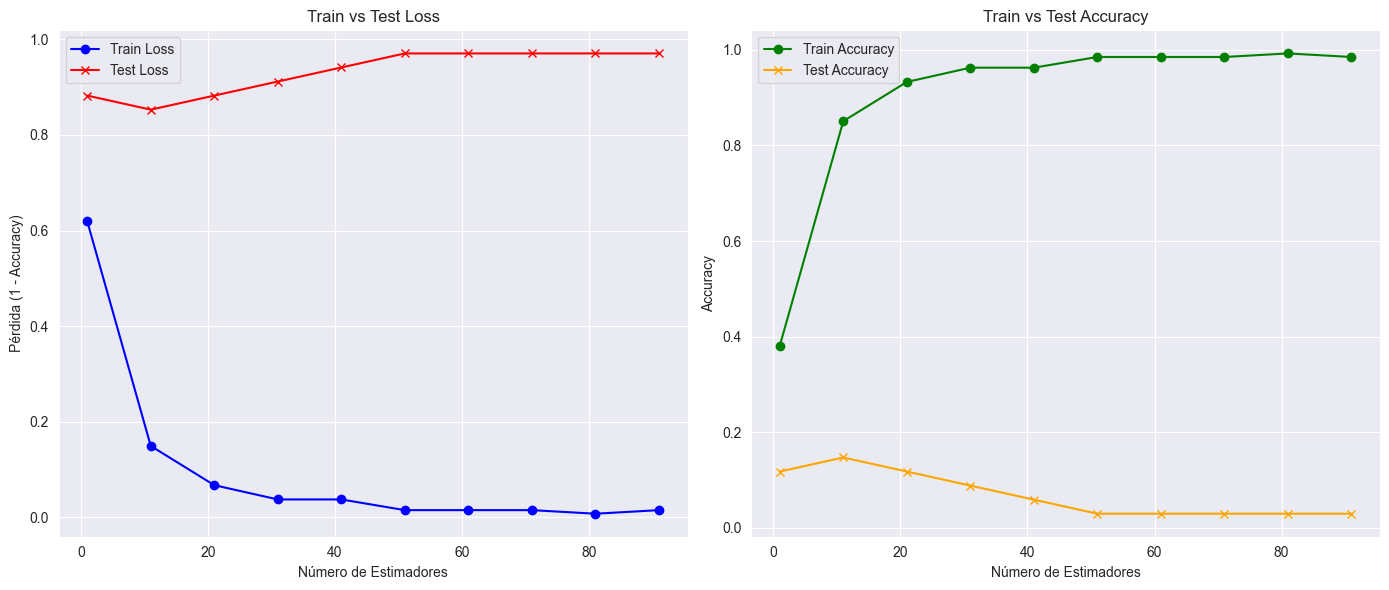

In [19]:
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

for n_estimators in range(1, 101, 10):
    best_rf.set_params(n_estimators=n_estimators)
    best_rf.fit(X_train, y_train)

    # Predicciones
    train_pred = best_rf.predict(X_train)
    test_pred = best_rf.predict(X_test)

    # Calcular Loss (1 - accuracy)
    train_loss.append(1 - accuracy_score(y_train, train_pred))
    test_loss.append(1 - accuracy_score(y_test, test_pred))

    # Calcular accuracy
    train_accuracy.append(accuracy_score(y_train, train_pred))
    test_accuracy.append(accuracy_score(y_test, test_pred))


fig, ax1 = plt.subplots(1, 2, figsize=(14, 6))

ax1[0].plot(range(1, 101, 10), train_loss, label='Train Loss', color='blue', marker='o')
ax1[0].plot(range(1, 101, 10), test_loss, label='Test Loss', color='red', marker='x')
ax1[0].set_xlabel('Número de Estimadores')
ax1[0].set_ylabel('Pérdida (1 - Accuracy)')
ax1[0].set_title('Train vs Test Loss')
ax1[0].legend()

ax1[1].plot(range(1, 101, 10), train_accuracy, label='Train Accuracy', color='green', marker='o')
ax1[1].plot(range(1, 101, 10), test_accuracy, label='Test Accuracy', color='orange', marker='x')
ax1[1].set_xlabel('Número de Estimadores')
ax1[1].set_ylabel('Accuracy')
ax1[1].set_title('Train vs Test Accuracy')
ax1[1].legend()

plt.tight_layout()
plt.show()

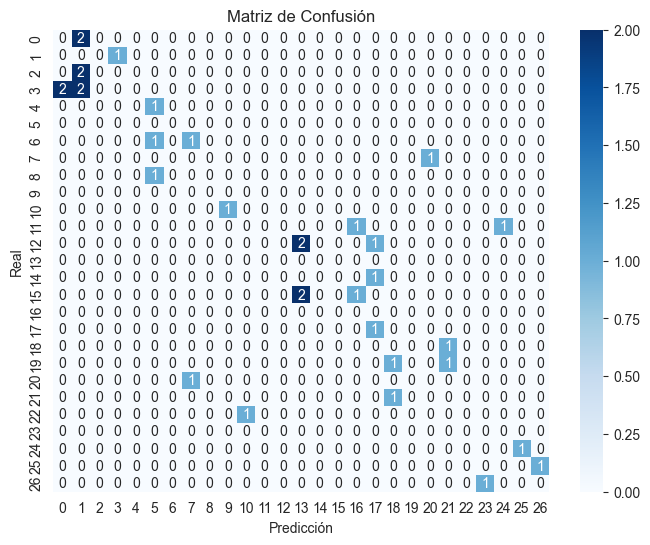

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

rf_test_pred = best_rf.predict(X_test)

conf_matrix = confusion_matrix(y_test, rf_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()


En el caso del archivo reducido no obtenemos buenos resultados. Esto se debe a que solo tenemos 4 datos por cada categoria. Esto se hace mientras no tenemos a mano el archivo extendido. Con el archivo extendido se espera obtener mejores resultados, porque tenemos más datos para cada categoría.